# Project description
You work for the OilyGiant mining company. Your task is to find the best place for a new well.
Steps to choose the location:
> - Collect the oil well parameters in the selected region: oil quality and volume of reserves;
> - Build a model for predicting the volume of reserves in the new wells;
> - Pick the oil wells with the highest estimated values;
> - Pick the region with the highest total profit for the selected oil wells.

You have data on oil samples from three regions. Parameters of each oil well in the region are already known  
Build a model that will help to pick the region with the highest profit margin. Analyze potential profit and risks using the Bootstrapping technique.
**Conditions:**
> - Only linear regression is suitable for model training (the rest are not sufficiently predictable).
> - When exploring the region, a study of 500 points is carried with picking the best 200 points for the profit calculation.
> - The budget for development of 200 oil wells is 100 USD million.
> - One barrel of raw materials brings 4.5 USD of revenue The revenue from one unit of product is 4,500 dollars (volume of reserves is in thousand barrels).
> - After the risk evaluation, keep only the regions with the risk of losses lower than 2.5%. From the ones that fit the criteria, the region with the highest average profit should be selected.
> - The data is synthetic: contract details and well characteristics are not disclosed.

**Data description**
Geological data for each region:
> - geo_data_0.csv
> - geo_data_1.csv
> - geo_data_2.csv
Columns: 
> - id — unique oil well identifier
> - f0, f1, r2 — three features of points (their specific meaning is unimportant, but the features themselves are significant)
> - product — volume of reserves in the oil well (thousand barrels).

# TOC
- [Project description](#Project-description)
- [TOC](#TOC)
- [1. Data and Lib import](#1.-Data-and-Lib-import)
- [2. Inspecting and preprocessing](#2.-Inspecting-and-preprocessing)
    * [2.1. Inspecting the data](#2.1.-Inspecting-the-data)
    * [2.1. Dropping invalid datapoints](#2.1.-Dropping-invalid-datapoints)
- [3. Machine learning](#3.-Machine-learning)
    * [3.1. Model training](#3.1.-Model-training)
    * [3.2. Model evaluation](#3.2.-Model-evaluation)
        + [3.2.1. Model quality](#3.2.1.-Model-quality)
        + [3.2.2. Average volume of wells](#3.2.2.-Average-volume-of-wells)
- [4. Profit calculations](#4.-Profit-calculations)
    * [4.1. Break even calculation](#4.1.-Break-even-calculation)
    * [4.2. Profit calculation of sample](#4.2.-Profit-calculation-of-sample)
- [5. Statistical risk and profit calculation](#5.-Statistical-risk-and-profit-calculation)
    * [5.1. Distribution of profit](#5.1.-Distribution-of-profit)
    * [5.2. Average profit](#5.2.-Average-profit)
- [5. Summary](#5.-Summary)

In [1]:
# Activate autocomplete
%config Completer.use_jedi = False

In [2]:
# Use the button below to toggle warnings
from IPython.display import HTML
HTML('''<script>
var code_show_err = false; 
var code_toggle_err = function() {
 var stderrNodes = document.querySelectorAll('[data-mime-type="application/vnd.jupyter.stderr"]')
 var stderr = Array.from(stderrNodes)
 if (code_show_err){
     stderr.forEach(ele => ele.style.display = 'block');
 } else {
     stderr.forEach(ele => ele.style.display = 'none');
 }
 code_show_err = !code_show_err
} 
document.addEventListener('DOMContentLoaded', code_toggle_err);
</script>
To toggle on/off output_stderr, click <a onclick="javascript:code_toggle_err()">here</a>.''')

# 1. Data and Lib import

In [3]:
import warnings
from collections import defaultdict

# Data manipulating and plotting imports
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
from scipy import stats as st
import seaborn as sns
%matplotlib inline

# ML import

warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
    
    
# Constants
RANDOM_STATE = 42

try:
    df_reg0 = pd.read_csv('./datasets/geo_data_0.csv')
    df_reg1 = pd.read_csv('./datasets/geo_data_1.csv')
    df_reg2 = pd.read_csv('./datasets/geo_data_2.csv')
except:
    df_reg0 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_0.csv')
    df_reg1 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_1.csv')
    df_reg2 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_2.csv')

display(df_reg0.head(2))

C:\Users\JonathanLang\.conda\envs\practicum\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\JonathanLang\.conda\envs\practicum\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\JonathanLang\.conda\envs\practicum\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)
C:\Users\JonathanLang\.conda\envs\practicum\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.22117,105.280062
1,2acmU,1.334711,-0.340164,4.36508,73.037750


# 2. Inspecting and preprocessing
> In this step an overall overview over the data has been archived as well as the crucial steps in preprocessing have been carried out

## 2.1. Inspecting the data
> In this step each region has been inspected to find annomalies, patterns and to get a basic understanding of the data

In [4]:
regions = (df_reg0, df_reg1, df_reg2)
for i, region in enumerate(regions):
    print(f'Overview region {i}')
    display(region.head(5))
    display(region.describe())
    display(region.info())
    unique_elements = region['id'].nunique()
    print(f'Unique elements: {unique_elements}')
    print(f'Number of duplicates: {region.duplicated().sum()}')
    print('#'*50)

Overview region 0


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

Unique elements: 99990
Number of duplicates: 0
##################################################
Overview region 1


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

Unique elements: 99996
Number of duplicates: 0
##################################################
Overview region 2


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

Unique elements: 99996
Number of duplicates: 0
##################################################


In [5]:
df_reg0.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


In [6]:
# Investigating why number of unique elements is < len of dataset
df_reg0['id'].nunique()
df_reg0['id'].value_counts().sort_values(ascending=False)

Tdehs    2
HZww2    2
A5aEY    2
74z30    2
AGS9W    2
        ..
Xfh6j    1
V5hFd    1
Dw4Yp    1
uIjtH    1
zBLJj    1
Name: id, Length: 99990, dtype: int64

In [7]:
# Investigation of unique elements
for region in regions:
    corrupt_ids = region['id'].value_counts().pipe(lambda x: x[x>1]).index
    display(region.query('id in @corrupt_ids'))

,id,f0,f1,f2,product
931,HZww2,0.755284,0.368511,1.863211,30.681774
1364,bxg6G,0.411645,0.856830,-3.653440,73.604260
1949,QcMuo,0.506563,-0.323775,-2.215583,75.496502
3389,A5aEY,-0.039949,0.156872,0.209861,89.249364
7530,HZww2,1.061194,-0.373969,10.430210,158.828695
16633,fiKDv,0.157341,1.028359,5.585586,95.817889
21426,Tdehs,0.829407,0.298807,-0.049563,96.035308
41724,bxg6G,-0.823752,0.546319,3.630479,93.007798
42529,AGS9W,1.454747,-0.479651,0.683380,126.370504
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205


,id,f0,f1,f2,product
1305,LHZR0,11.170835,-1.945066,3.002872,80.859783
2721,bfPNe,-9.494442,-5.463692,4.006042,110.992147
5849,5ltQ6,-3.435401,-12.296043,1.999796,57.085625
41906,LHZR0,-8.989672,-4.286607,2.009139,57.085625
47591,wt4Uk,-9.091098,-8.109279,-0.002314,3.179103
82178,bfPNe,-6.202799,-4.820045,2.995107,84.038886
82873,wt4Uk,10.259972,-9.376355,4.994297,134.766305
84461,5ltQ6,18.213839,2.191999,3.993869,107.813044


,id,f0,f1,f2,product
11449,VF7Jo,2.122656,-0.858275,5.746001,181.716817
28039,xCHr8,1.633027,0.368135,-2.378367,6.120525
43233,xCHr8,-0.847066,2.101796,5.597130,184.388641
44378,Vcm5J,-1.229484,-2.439204,1.222909,137.968290
45404,KUPhW,0.231846,-1.698941,4.990775,11.716299
49564,VF7Jo,-0.883115,0.560537,0.723601,136.233420
55967,KUPhW,1.211150,3.176408,5.543540,132.831802
95090,Vcm5J,2.587702,1.986875,2.482245,92.327572


> **Observations:**
> - There are no missing datapoints 
> - There are some ids assigned more than once but they are no duplicates. -> Drop them because something went wrong here with aggregating the data. (4-10 values which is less then 0.01% of the data.)
> - The mean of region 0 and 2 is significant higher than the region in 2

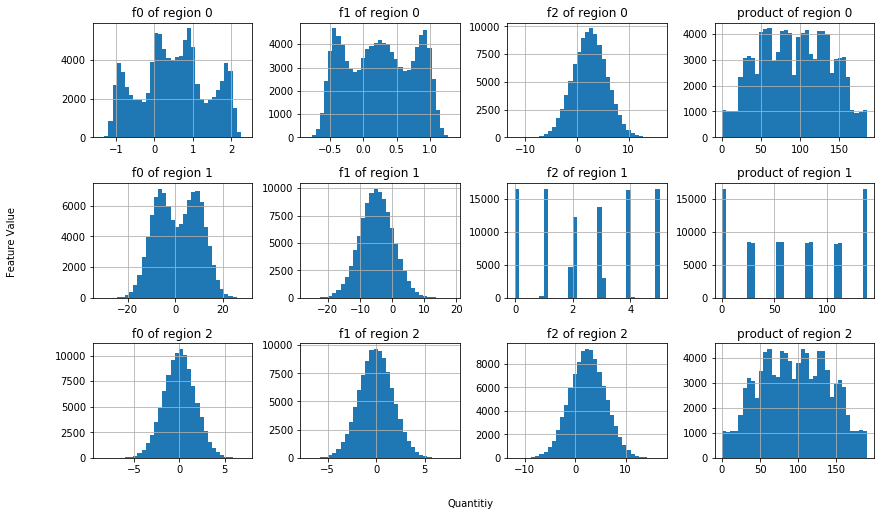

In [8]:
# Investigation of derivation of features and targets
col_name = df_reg0.columns[1:]
regi = ('region 0', 'region 1', 'region 2')
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(14, 8))
plt.subplots_adjust(hspace=0.4, wspace=0.3)
for j, region in enumerate(regions):
    for i, col in enumerate(region.columns[1:]):
        region[col].hist(bins=35, ax=ax[j, i])
        ax[j,i].set_title(col_name[i]+ ' ' + 'of' + ' ' + regi[j])
fig.text(0.5, 0.04, 'Quantitiy', ha='center');
fig.text(0.04, 0.5, 'Feature Value', va='center', rotation='vertical');

> **Observations:**
> - The distribuitions of the population of the product of region 1 and 2 are almost equal whereas the the distribution of region 1 differs completely
> f2 seems to have a crucial influence of the distribution of the population

region 0


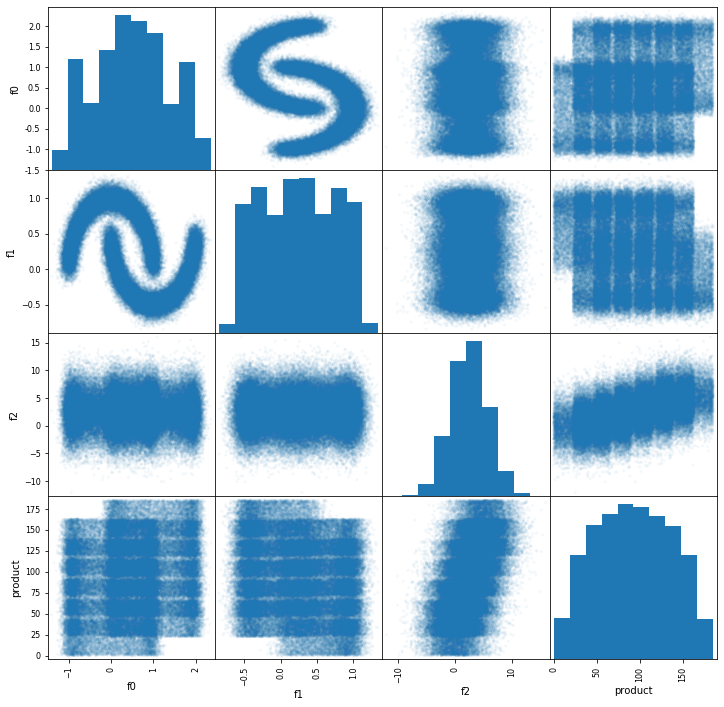

region 1


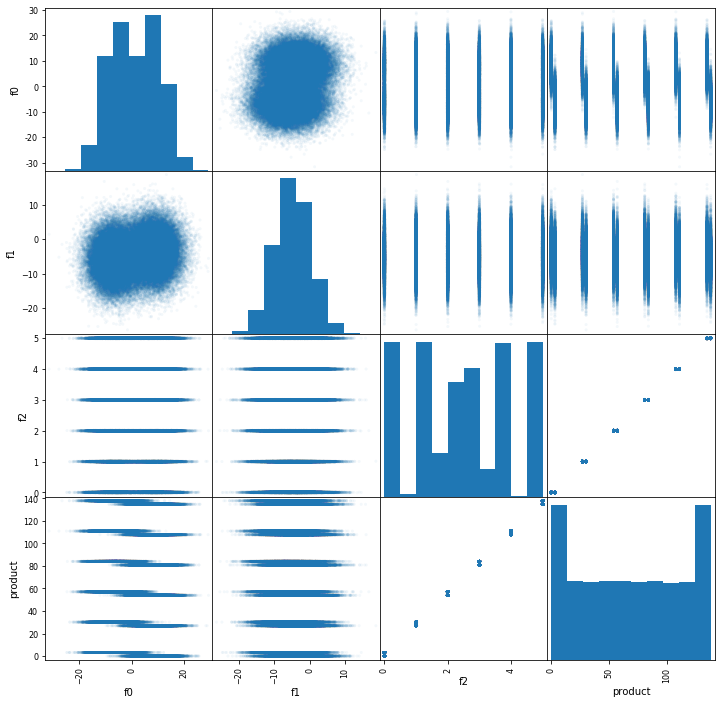

region 2


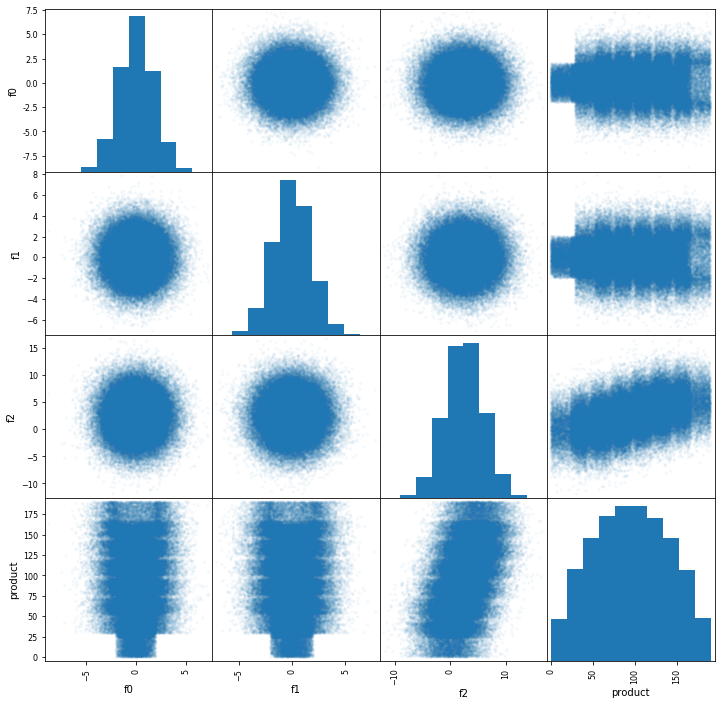

In [9]:
for i, region in enumerate(regions):
    print(regi[i])
    pd.plotting.scatter_matrix(region, figsize=(12,12), alpha=0.05)
    plt.show()

> **Observations:**
> - The distributions of region 0,2 for the product are more similar whereas region 1 differs drastically. 
> - \-\> region 1 is much more linear and has less variance and a far lower standard derivation so that the model accuracy there should be much higher than for the models of region 0 and 2

## 2.1. Dropping invalid datapoints
> In this step the datapoint where the id doubles will be dropped

In [10]:
for region in regions:
    # Aggregating list of ids to drop
    corrupt_ids = region['id'].value_counts().pipe(lambda x: x[x>1]).index
    # Aggregating indexes of ids 
    idx_to_drop = region.query('id in @corrupt_ids').index
    # Dropping double ids
    region.drop(idx_to_drop, inplace=True)

# 3. Machine learning

## 3.1. Model training
> As mentioned in the first condition of the project, Linear regression is used for this project.  
> Thus, for each region a Model has been trained in this step 

In [11]:
# Prepare dict for data
models = {region: defaultdict() for region in ('r0', 'r1', 'r2')}

# Train models and aggergate all needed infos for the rest of the project
for r_name, region in zip(('r0', 'r1', 'r2'), regions):
    features = region.drop(['id', 'product'], axis=1)
    target = region['product']
    X_train, X_test, y_train, y_test = train_test_split(features,
                                                        target,
                                                        test_size=0.25,
                                                        random_state=RANDOM_STATE )
    # Instance and train model
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Aggregate data
    y_predict = model.predict(X_test)
    mse = mean_squared_error(y_test, y_predict)
    score = model.score(X_test, y_test)
    
    models[r_name].update({
        'model': model,
        'y_test': y_test,
        'y_predict': pd.Series(y_predict, index=y_test.index), 
        'mse': mse,
        'r2': score
    })

## 3.2. Model evaluation
> In this chapter the model quality will be evaluated according to their MSE and the r2 score.  
> Additional to that, the predictions of the model regarding the predicted volumes of the oil wells.

### 3.2.1. Model quality
> In this chapter the model quality will be evaluated according to their MSE and the r2 score.  

In [12]:
# Outuptting MSE for regions
for k in models.keys():
    print(f'MSE for model {k} is:', models[k]['mse'])

MSE for model r0 is: 1425.904233777253
MSE for model r1 is: 0.7972053901293501
MSE for model r2 is: 1610.5096501229355


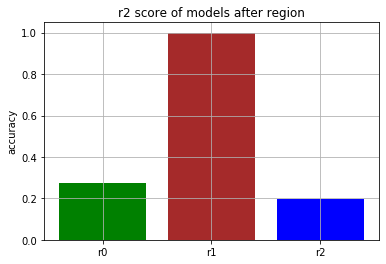

In [13]:
# Plotting r2 scores after region:
r2_scores = [models[k]['r2'] for k in models.keys()]
x_pos = np.arange(len(r2_scores))
bars = models.keys()

plt.bar(x_pos, r2_scores, color=['green','brown', 'blue'])
plt.xticks(x_pos, bars)
plt.ylabel('accuracy')
plt.title('r2 score of models after region')
plt.grid()
plt.show()

> **Observations:**
> - The MSE of region 1 is significant lower than the one in region 0 and 2 (Factor 1900)
> - The RMSE with 40 for region 2 is quite high. (taking into consideration that mean of oil wells is 96)
> - The model quality (r2 score) for model of region 1 is wit 99.96% significant higher than region 0 and 2 with scores around 20-26

### 3.2.2. Average volume of wells
> In this chapter the predictions of the model has been evaluated in different ways

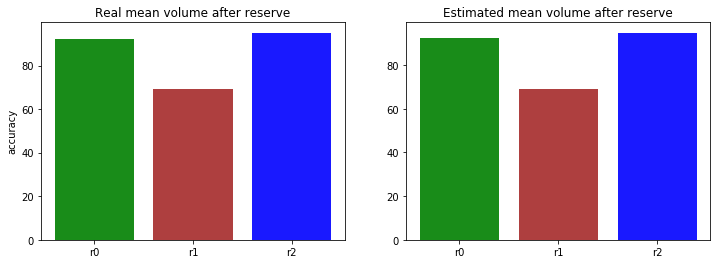

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

# Plotting means for region:
tot_mean_volume_real = [np.mean(models[k]['y_test']) for k in models.keys()]
tot_mean_volume_est = [np.mean(models[k]['y_predict']) for k in models.keys()]

x_pos = np.arange(len(tot_mean_volume_real))
bars = models.keys()

ax[0].bar(x_pos, tot_mean_volume_real, color=['green','brown', 'blue'], alpha=0.9)
ax[1].bar(x_pos, tot_mean_volume_est, color=['green','brown', 'blue'], alpha=0.9)
plt.setp(ax, xticks=x_pos, xticklabels=bars)
ax[0].set_ylabel('accuracy')
ax[1].set_title('Estimated mean volume after reserve')
ax[0].set_title('Real mean volume after reserve')
plt.plot();

> **Observations:**
> - The means are nearly identical which means that the models in mean are  quite accurate
> - \-\> Evaluation of top 500 and top 200 wells needs to be carried out according to project conditions

In [15]:
# Aggregating top 500 reserves
top_500_real = [
    models[k]['y_test'].sort_values(ascending=False)[:500] for k in models.keys()
]

# Aggregating top 500 according predictions
top_500_estimated = [
    models[k]['y_predict'].loc[top_500_real[i].index] for i,k in enumerate(models.keys())
]

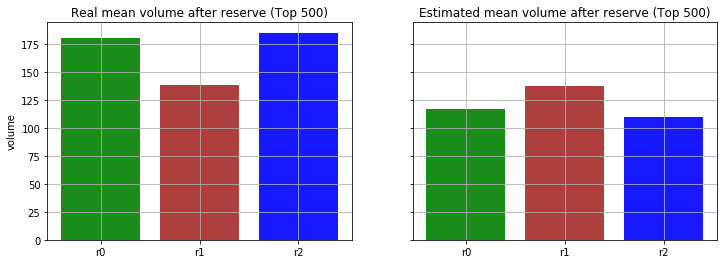

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4), sharey=True)

# Plotting means for region:
mean_volume_real = [np.mean(reg) for reg in top_500_real]
mean_volume_est = [np.mean(reg) for reg in top_500_estimated]

x_pos = np.arange(len(mean_volume_real))
bars = models.keys()

ax[0].bar(x_pos, mean_volume_real, color=['green','brown', 'blue'], alpha=0.9)
ax[1].bar(x_pos, mean_volume_est, color=['green','brown', 'blue'], alpha=0.9)
plt.setp(ax, xticks=x_pos, xticklabels=bars)
ax[0].set_ylabel('volume')
ax[1].set_title('Estimated mean volume after reserve (Top 500)')
ax[0].set_title('Real mean volume after reserve (Top 500)')
ax[0].grid()
ax[1].grid()
plt.plot();

In [17]:
# calculate mean differences
mean_diffs = [i-j for i,j in zip(mean_volume_real, mean_volume_est)]
for i, region in enumerate(regi):
    print('Difference estimated and real mean top 500 in {}: {:.2f},' \
          ' squared: {:.2f}'.format(
                region, mean_diffs[i], mean_diffs[i]**2)
         )

Difference estimated and real mean top 500 in region 0: 63.40, squared: 4019.97
Difference estimated and real mean top 500 in region 1: 0.49, squared: 0.24
Difference estimated and real mean top 500 in region 2: 75.01, squared: 5626.35


> **Observations:**
> - The real mean volume of top 500 is the highest in region 2 and 0. (Around 180) Whereas the real mean value of region 1 is around 130.
> - In contrast to that, the mean prediction of the top 500 spots form the model shows complete different results: 
>     - r1 has the highest average which is around the same level than the real average (130)
>     - the mean of predicted means for r0 and r2 decreased to around 115 and are now lower than region 1 
>     - The mean decreased around 70 units for region 0 and 2 (in middle) wherease the mean in region decreased just 0.49 units
>     - The mean squared error for the top 500 is over 4000 for region 0 and over 5600 for region 2 and so massively over the mse of the models (1400-1600)

# 4. Profit calculations
> In this steps the profit calculations has been prepared and carried out. Therefore the parameter and circumstances listed in the conditions are applied:
> - When exploring the region, a study of 500 points is carried with picking the best 200 points for the profit calculation.
> - The budget for development of 200 oil wells is 100 USD million.
> - One barrel of raw materials brings 4.5 USD of revenue The revenue from one unit of product is 4,500 dollars (volume of reserves is in thousand barrels).
> - After the risk evaluation, keep only the regions with the risk of losses lower than 2.5%. From the ones that fit the criteria, the region with the highest average profit should be selected.

> **Regarding the risk evaluation the real parameters have been choosen, not the predicted**


## 4.1. Break even calculation
> In the following step the minimum volume for an oil well is calculated so that by developing it no losses occur.   
> Therefore the assumption is made that every oil well costs the same

In [18]:
# Storing key variables:
budget = 100000000
well_cnt = 200
price_per_barrel = 4.5
product_barrel_factor = 1000

In [19]:
# Break even per well:
cost_per_well = budget / well_cnt
volume_break_even = cost_per_well / (product_barrel_factor * price_per_barrel)

In [20]:
# Aggregating dataframe to comapre outcomes of break even data
top_500_means = pd.DataFrame((mean_volume_real, mean_volume_est),
                             columns=('r0', 'r1', 'r2'),
                             index=('top_500_real', 'top_500_est'))
total_means = pd.DataFrame((tot_mean_volume_real, tot_mean_volume_est),
                           columns=('r0', 'r1', 'r2'),
                           index=('tot_real', 'tot_est'))
mean_overview = pd.concat((total_means, top_500_means))
print('Minimal volume for break even: {:.2f}'.format(volume_break_even))
mean_overview

Minimal volume for break even: 111.11


,r0,r1,r2
tot_real,92.374915,69.164936,95.058583
tot_est,92.286539,69.168941,94.820691
top_500_real,180.435495,137.945408,184.881025
top_500_est,117.032225,137.450513,109.871997


> **Observations:**
> - the mean of the whole testset for each region is below the threshold 
> - the top 500 for the whole testset (real data) the mean is over the threshold for each region 
> - Region 2 in predicted top 500 datapoints is below the threshold whereas the region 0 and one are above it

## 4.2. Profit calculation of sample
> In this step a sample of 500 wells per region are piced randomly. From those 500 points per region, the best 200 Wells will be choosen and the average profit will be calculated for eachr region

In [21]:
def calc_profit(samples, cost_per_well):
    profit = 0
    for sample in samples:
        profit += sample * price_per_barrel * product_barrel_factor - cost_per_well
        #print(profit)
    return profit

In [22]:
# Aggregating all model estimations in one list
y_predict = [models[k]['y_predict'] for k in models.keys()]

In [23]:
# Getting Samples with samplesize 500 from predicted values
samples_r0 = y_predict[0].sample(500, random_state=RANDOM_STATE)
samples_r1 = y_predict[1].sample(500, random_state=RANDOM_STATE)
samples_r2 = y_predict[2].sample(500, random_state=RANDOM_STATE)

In [24]:
# Slicing top 200 samples per region from sample 
samples_r0_top = samples_r0.sort_values(ascending=False)[:200]
samples_r1_top = samples_r1.sort_values(ascending=False)[:200]
samples_r2_top = samples_r2.sort_values(ascending=False)[:200]

In [25]:
# Calculating profit with real values
samples = [samples_r0, samples_r1, samples_r2]
region_values = [region['product'] for region in regions]

for sample, true_vals in zip(samples, region_values):
    smean = true_vals.loc[sample.index].mean()
    print('Sample mean: {:.2f}'.format(smean))
    print('Profit: {:.2f} USD'.format(
            calc_profit(true_vals.loc[sample.index], cost_per_well)))
    print('#'*24)

Sample mean: 90.71
Profit: -45908411.68 USD
########################
Sample mean: 70.30
Profit: -91835776.27 USD
########################
Sample mean: 95.39
Profit: -35371256.44 USD
########################


> For the 500 randomly selected points, the mean is below thre thershold and there would be a loss by developing all spotts to wells. In the next step the 200 top samples per region will be checked

In [26]:
# Estimating profit on ML model estimations
samples_top = [samples_r0_top, samples_r1_top, samples_r2_top]
profit_top_predict = []
for sample in samples_top:
    profit = calc_profit(sample, cost_per_well)
    profit_top_predict.append(profit)
    print('Worsed well in sample of region: {:.2f} * 10³ Barrel'.format(min(sample)))
    print('Sample mean: {:.2f} * 10³ Barrel'.format(sample.mean()))
    print('Profit: {:.2e} USD'.format(profit))
    print('total_volume: {:.2f} * 10³ Barrel'.format(sample.sum()))
    print('#'*52)

Worsed well in sample of region: 97.85 * 10³ Barrel
Sample mean: 114.85 * 10³ Barrel
Profit: 3.37e+06 USD
total_volume: 22970.62 * 10³ Barrel
####################################################
Worsed well in sample of region: 83.43 * 10³ Barrel
Sample mean: 118.13 * 10³ Barrel
Profit: 6.32e+06 USD
total_volume: 23625.59 * 10³ Barrel
####################################################
Worsed well in sample of region: 100.63 * 10³ Barrel
Sample mean: 116.29 * 10³ Barrel
Profit: 4.66e+06 USD
total_volume: 23257.60 * 10³ Barrel
####################################################


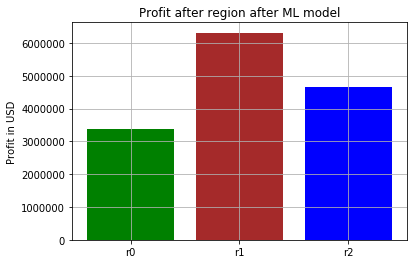

In [27]:
# Plotting Expected profit after region for estimated outcome
x_pos = np.arange(len(profit_top_predict))
bars = models.keys()

plt.bar(x_pos, profit_top_predict, color=['green','brown', 'blue'])
plt.xticks(x_pos, bars)
plt.ylabel('Profit in USD')
plt.title('Profit after region after ML model')
plt.grid()
plt.show()

In [28]:
samples_top = [samples_r0_top, samples_r1_top, samples_r2_top]
profit_top = []

for sample, true_vals in zip(samples_top, region_values):
    profit = calc_profit(true_vals.loc[sample.index], cost_per_well)
    profit_top.append(profit)
    print('Worsed well in sample of region: {:.2f} * 10³ Barrel'.format(
            min(true_vals.loc[sample.index])
    ))
    print('Sample mean: {:.2f} * 10³ Barrel'.format(true_vals.loc[sample.index].mean()))
    print('Profit: {:.2e} USD'.format(profit))
    print('total_volume: {:.2f} * 10³ Barrel'.format(true_vals.loc[sample.index].sum()))
    print('#'*52)


Worsed well in sample of region: 5.45 * 10³ Barrel
Sample mean: 116.65 * 10³ Barrel
Profit: 4.98e+06 USD
total_volume: 23329.80 * 10³ Barrel
####################################################
Worsed well in sample of region: 80.86 * 10³ Barrel
Sample mean: 118.19 * 10³ Barrel
Profit: 6.38e+06 USD
total_volume: 23638.98 * 10³ Barrel
####################################################
Worsed well in sample of region: 24.24 * 10³ Barrel
Sample mean: 119.41 * 10³ Barrel
Profit: 7.47e+06 USD
total_volume: 23882.31 * 10³ Barrel
####################################################


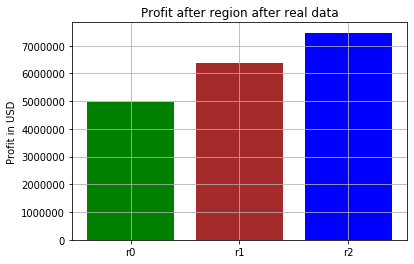

In [29]:
# Plotting Expected profit after region for estimated outcome
x_pos = np.arange(len(profit_top))
bars = models.keys()

plt.bar(x_pos, profit_top, color=['green','brown', 'blue'])
plt.xticks(x_pos, bars)
plt.ylabel('Profit in USD')
plt.title('Profit after region after real data')
plt.grid()
plt.show()

> **Observation:**
> - Every region of the samples seems to be profitable
> - Region 2 has the highest profit and should be developed. Therefore the wells have been selected by the prediction of the ML model and the real values have been used for calculating the profit.
> - Region 0 has the lowest expected profit.
> - The real profit and the expected profit for Model 0 and 2 are differing significantly because their model quality is significant lower than the one of region 1. In combination with the fact that the real high values of region 0 and 2 are based on the previously shown high distribution (MSE 5626.35 for top 500 against 1600 for the whole dataset), the model is not able to predict those good wells.

# 5. Statistical risk and profit calculation
> In this step the risk and profit calculation are done for each region

## 5.1. Distribution of profit
> For this step bootstrapping with 1000 sub-samples is carried out. The sample size of the the population are the in the previous chapter randomly selected 500 samples per region

In [30]:
y_predict = [models[k]['y_predict'] for k in models.keys()]

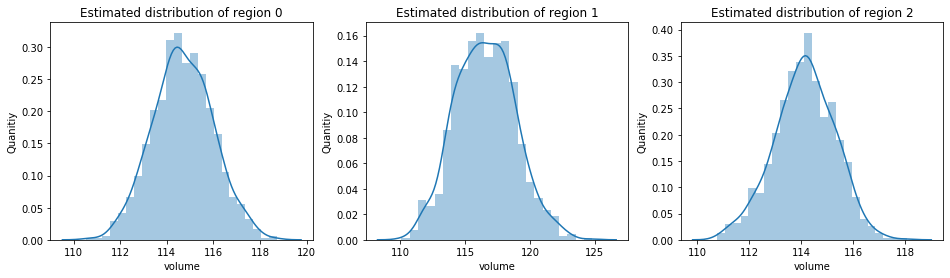

In [31]:
# Determine the distribution of volumes
bootstrap = 1000
subsize = 500
fig, ax = plt.subplots(ncols=3, nrows=1, figsize = (16,4))
sample_vol_means = []
for idx, region in enumerate(y_predict):
    sample_mean = []
    for i in range(0, bootstrap):
        sample_n = region.sample(500, replace=True, random_state=i)
        sample_n_200 = sorted(sample_n, reverse=True)[:200]
        sample_mean.append(np.mean(sample_n_200))
    ax[idx]=sns.distplot(sample_mean, ax=ax[idx])
    ax[idx].set_title('Estimated distribution of' + ' ' + regi[idx])
    ax[idx].set_xlabel('volume')
    ax[idx].set_ylabel('Quanitiy')
    sample_vol_means.append(sample_mean)

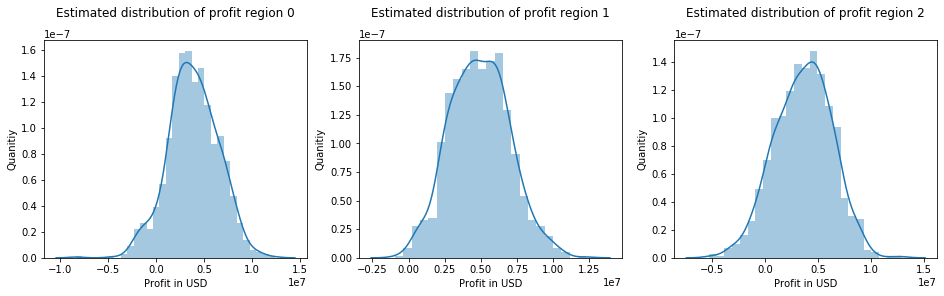

In [32]:
# Determine the distributin of profits
bootstrap = 1000
subsize = 500
fig, ax = plt.subplots(ncols=3, nrows=1, figsize = (16,4))
sample_profits = []

for idx, (region, real_vals) in enumerate(zip(y_predict, region_values)):
    sample_profit = []
    for i in range(0, bootstrap):
        sample_n = region.sample(subsize, replace=True, random_state=i)
        sample_n_200 = sample_n.sort_values(ascending=False)[:200]
        sample_profit_ = calc_profit(real_vals.loc[sample_n_200.index], cost_per_well)
        sample_profit.append(sample_profit_)
    ax[idx]=sns.distplot(sample_profit, ax=ax[idx])
    ax[idx].set_title('Estimated distribution of profit' + ' ' + regi[idx],y=1.08)
    ax[idx].set_xlabel('Profit in USD')
    ax[idx].set_ylabel('Quanitiy')
    sample_profits.append(sample_profit)

> **Observations:**
> - region 2 shows the highest potential for profit and the smallest chance for loss. Those probabilities and confidence intervalls will be calculated in the next step
> - The Distirbution for all regions include a financially risk
> - All distributions are more or less normal distributed (except region 1)

## 5.2. Average profit
> In this chapter the average profit, the 95% confidence intervall and the probability of a loss is calculated.

In [33]:
# Average profit after region
profits_after_reg = [np.mean(region) for region in sample_profits]
for idx, region in enumerate(profits_after_reg):
    print(f'Average profit in {regi[idx]}: {region}')

Average profit in region 0: 3882144.9348104782
Average profit in region 1: 4907188.381747974
Average profit in region 2: 3619680.4762510075


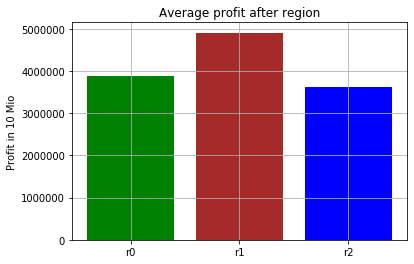

In [34]:
# Plotting r2 scores after region:
x_pos = np.arange(len(profit_top))
bars = models.keys()

plt.bar(x_pos, profits_after_reg, color=['green','brown', 'blue'])
plt.xticks(x_pos, bars)
plt.ylabel('Profit in 10 Mio')
plt.title('Average profit after region')
plt.grid()
plt.show()

In [35]:
# Determining 95% quantile:
quant = 0.95
alpha_lower = .025
alpha_upper = .975

In [36]:
for region, smp in zip(regi, sample_profits):
    values = pd.Series(smp)
    upper = values.quantile(alpha_upper)
    lower = values.quantile(alpha_lower)
    print(
        '95% confidence intervall for {}: {:.2e} - {:.2e} USD'.format(
        region, lower, upper)
         )

95% confidence intervall for region 0: -1.62e+06 - 8.73e+06 USD
95% confidence intervall for region 1: 8.66e+05 - 9.10e+06 USD
95% confidence intervall for region 2: -1.66e+06 - 8.67e+06 USD


> **Observations:**
> - Region 1 has the best performance in the 95% confidence intervall (Range displayed above)
> - There is no possibility for a loss in the randomly selected sample within the 95% confidence intervall. The profit is within this intervall always greater than 9.69*e+05 USD
> - The risk of losses is only given for r0

In [37]:
# Calculating risk of loss
# Determining loss threshold for region 0:
threshold_r0 = 0.06858586
threshold_r0_l = 0.06853535
profit_threshold_r0_u = pd.Series(sample_profits[0]).quantile(threshold_r0)
print('Profit region 0 at {:.6%}:  {:.2f} USD'.format(threshold_r0, profit_threshold_r0_u))
profit_threshold_r0_l = pd.Series(sample_profits[0]).quantile(threshold_r0_l)
print('Profit region 0 at {:.6%}:  {:.2f} USD'.format(threshold_r0_l, profit_threshold_r0_l))

Profit region 0 at 6.858586%:  1365.08 USD
Profit region 0 at 6.853535%:  -8.83 USD


In [38]:
# Calculating risk of loss
# Determining loss threshold for region 1:
threshold_r1 = 0.00363636
threshold_r1_l = 0.00363131
profit_threshold_r1_u = pd.Series(sample_profits[1]).quantile(threshold_r1)
print('Profit region 1 at {:.6%}:  {:.2f} USD'.format(threshold_r1, profit_threshold_r1_u))
profit_threshold_r1_l = pd.Series(sample_profits[1]).quantile(threshold_r1_l)
print('Profit region 1 at {:.6%}:  {:.2f} USD'.format(threshold_r1_l, profit_threshold_r1_l))

Profit region 1 at 0.363636%:  168.48 USD
Profit region 1 at 0.363131%:  -656.80 USD


In [39]:
# Calculating risk of loss
# Determining loss threshold for region 0:
threshold_r2 = 0.09222222
threshold_r2_l = 0.09232323
profit_threshold_r2_u = pd.Series(sample_profits[2]).quantile(threshold_r2)
print('Profit region 2 at {:.6%}:  {:.2f} USD'.format(threshold_r2, profit_threshold_r2_u))
profit_threshold_r2_l = pd.Series(sample_profits[2]).quantile(threshold_r2_l)
print('Profit region 2 at {:.6%}:  {:.2f} USD'.format(threshold_r2_l, profit_threshold_r2_l))

Profit region 2 at 9.222222%:  -2813.32 USD
Profit region 2 at 9.232323%:  828.75 USD


> **Observations:**
> - Rist for loss in region 1 is around 0.36%
> - Other regions were investigated but withou a chance for loss

# 5. Summary
> In this project the following steps have been carried out:
> - Preprocessing data and identifying features and targets
> - Training and evaluating a linear regression model for estimating the volume of a well based on 3 parameter
> - Implementing functionalities for calculating profits
> - Statistical risk and Profit calculation

> machine learning
> The machine learning algorithms for this project differ drastically between the regions. The quality (R² score min:25 in region 0 and max 99.9% in region1). The reasons for the differing results are already explained previously. Because of the combination of linear regression as Machine learning algorithm and the high variance / Std of region 0 and 1 the top spots are not predicted correctly whereas region 3 with a MSE below 1 is predicting even the good wells correct. 

> Based on the previously carried out steps the new 200 wells should be developed in region 1. This region is choose because it has the highest to expecting profit with a minimal chance of losses compared to region 0 and 2. Furthermore the Model for predicting the volume of the wells is more accurat, the risk is again quite lower